# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import glob
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

# sudo mount -t drvfs '\\drive.irds.uwa.edu.au\OGS-ODFDA-001' /mnt/share

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [8]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (112.35, 113.85)
LAT_LIMITS = (-20.75, -19.45)  
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2024-06-01T00:00:00", "2024-10-01T00:00:00"]

crop_app = 'scarborough_winter24'

# # Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
# alldata_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'all')
# cropped_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'browse')

base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [3]:
# crop_app = 'browse_basin_winter24'

# # Download the data
# himawari.get_sst_series_nasa(time_lims, alldata_dir)

In [ ]:
# Crop himawari files (optional)

# # Setting ow=True will delete the original files after cropping (can also just set file_app='')
# himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

In [5]:
# # Move the new files to another folder
# move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     shutil.move(mf, os.path.join(cropped_dir, f_name))

In [6]:
# # Load the data
# ds = himawari.process_sst_series(cropped_dir, time_lims, ll_box, file_app=crop_app)
# ds

In [9]:
# Optional: save joined DS and delete individual cropped files
# ds.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))
ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))
ds

# Keeping the original files for now
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     os.remove(os.path.join(cropped_dir, f_name))

<xarray.Dataset> Size: 51MB
Dimensions:    (time: 2911, lat: 22, lon: 25)
Coordinates:
  * time       (time) datetime64[ns] 23kB 2024-06-01 ... 2024-09-30T23:00:00
  * lat        (lat) float64 176B -20.73 -20.67 -20.61 ... -19.59 -19.53 -19.47
  * lon        (lon) float64 200B 112.4 112.4 112.5 112.5 ... 113.7 113.8 113.8
    LON        (lat, lon) float64 4kB ...
    LAT        (lat, lon) float64 4kB ...
    X          (lat, lon) float64 4kB ...
    Y          (lat, lon) float64 4kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 13MB ...
    dTdt       (time, lat, lon) float64 13MB ...
    dTdx       (time, lat, lon) float64 13MB ...
    dTdy       (time, lat, lon) float64 13MB ...

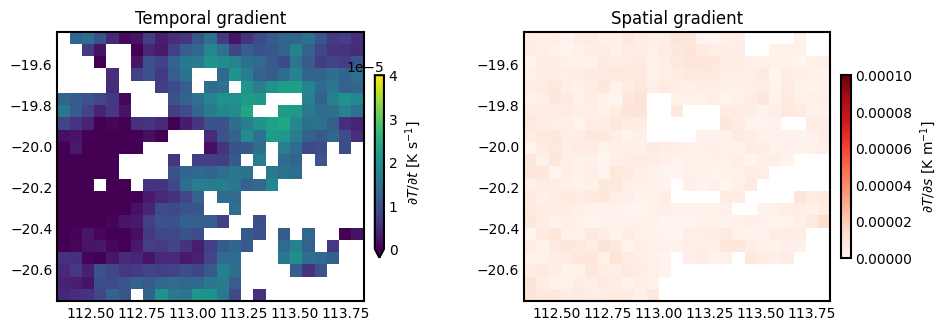

In [8]:
fig, ax = plots.plot_gradients(ds.isel(time=0), sg_names=['dTdx','dTdy'])

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [9]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(1, 'D').astype('timedelta64[ns]')

# results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=os.path.join(cropped_dir, f'{crop_app}_fits_1D.nc'), callback='off')

Running GP optimization


In [10]:
ds_results = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_fits_1D.nc'))
ds_results.close()
ds_results

<xarray.Dataset> Size: 256kB
Dimensions:    (time: 2911)
Coordinates:
  * time       (time) datetime64[ns] 23kB 2024-06-01 ... 2024-09-30T23:00:00
Data variables:
    sigma_u    (time) float64 23kB ...
    l_u        (time) float64 23kB ...
    tau_u      (time) float64 23kB ...
    sigma_S    (time) float64 23kB ...
    l_S        (time) float64 23kB ...
    tau_S      (time) float64 23kB ...
    sigma_tau  (time) float64 23kB ...
    l_v        (time) float64 23kB ...
    sigma_v    (time) float64 23kB ...
    tau_v      (time) float64 23kB ...

In [11]:
print("Calculating GP regression prediction")
# ds_full = gpr.predict_series(ds.sel(time=ds_results.time), ds_results)
# ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_predictions_1D.nc'))
ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_predictions_1D.nc'))

Calculating GP regression prediction


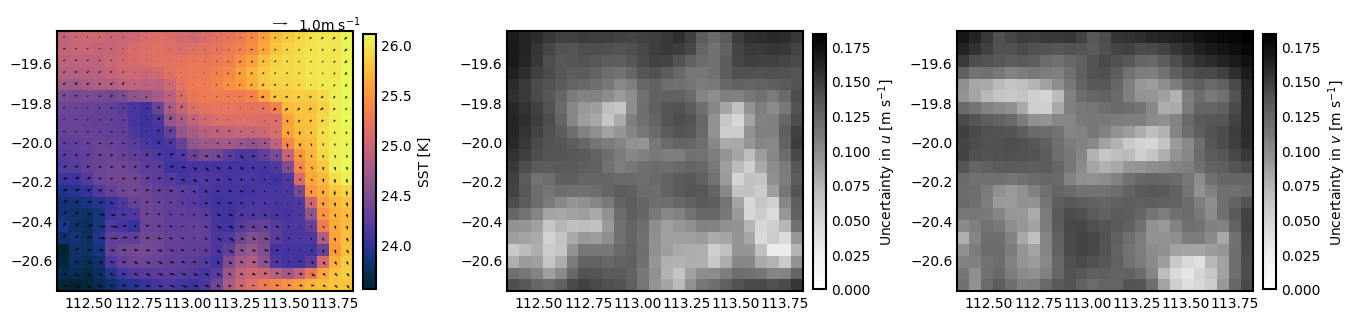

In [12]:
fig, ax = plots.plot_prediction(ds_full.isel(time=-6), qk_size=1., qv_scale=20)

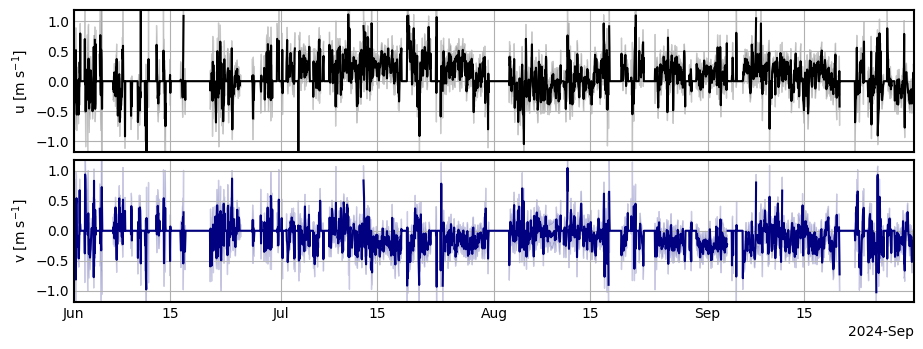

In [19]:
fig, ax = plots.plot_timeseries(ds_full, lon_pt=123.3744, lat_pt=-13.74942)
for x in ax:
    x.set_ylim(-1.19,1.19)
    # x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))

## Some analysis

In [ ]:
import pIMOS.utils.catalogue as pcat

# Load the DWR data
exp = 'Shell'
moor = 'DWR'
exp_base = os.path.join(base_dir, exp, 'data', 'moored_instrument_data')

root_folder = os.path.join(exp_base, exp, 'data', 'moored_instrument_data')
cat = pcat.get_pimos_catalogue(root_folder, is_moored=True)

# Load the most recent DWR file
ds = xr.open_dataset(cat['nc_path'].loc[cat['Group']==moor].values[-1], decode_times=True)
ds

In [24]:
import pandas as pd
from wootils.filters import check_spacing, filter1d_xr

print(check_spacing(ds_full['time'].values))

ds_full = ds_full.where(np.abs(ds_full['mu_u']) < 1.2)
ds_full = ds_full.where(np.abs(ds_full['mu_v']) < 1.2)

full_time = pd.date_range(start=ds_full['time'].min().values, end=ds_full['time'].max().values, freq='h')
ds_full = ds_full.reindex({'time': full_time}, fill_value=0)

ds_full['mu_u_lp'] = filter1d_xr(ds_full['mu_u'].fillna(0), 40, 60, ftype='lowpass', axis=0)
ds_full['mu_v_lp'] = filter1d_xr(ds_full['mu_v'].fillna(0), 40, 60, ftype='lowpass', axis=0)

True


<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_28133/3258587363.py:17: SyntaxWarning: invalid escape sequence '\o'
  ax[0].set_ylabel('$\overline{u}$ [m s$^{-1}$]')
/tmp/ipykernel_28133/3258587363.py:18: SyntaxWarning: invalid escape sequence '\o'
  ax[1].set_ylabel('$\overline{v}$ [m s$^{-1}$]')


Text(0, 0.5, '$\\overline{v}$ [m s$^{-1}$]')

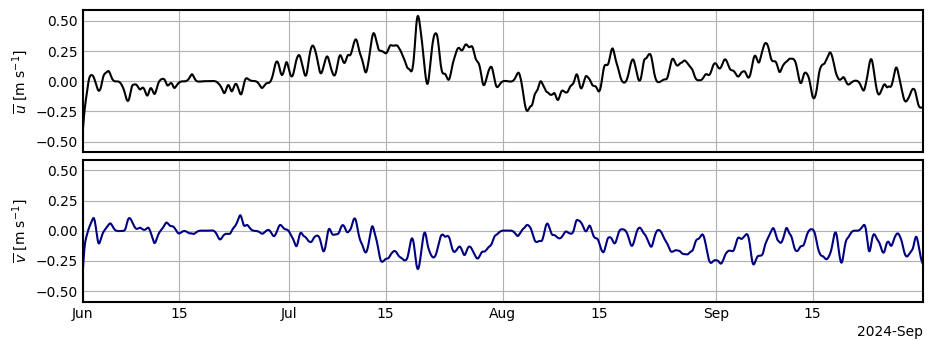

In [26]:
ds_point = ds_full.sel(lon=123.3744, lat=-13.74942, method='nearest')

fig, ax = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'hspace':0.05})

ds_point['mu_u_lp'].plot(ax=ax[0], label='u velocity', c='k')

ds_point['mu_v_lp'].plot(ax=ax[1], label='v velocity', c='navy')

for x in ax:
    x.set_xlabel('')
    x.set_title('')
    x.set_ylim(-0.59, 0.59)
    x.grid()
    x.set_xlim(ds_point['time'].values[0], ds_point['time'].values[-1])

ax[0].set_xticklabels([])
ax[0].set_ylabel('$\overline{u}$ [m s$^{-1}$]')
ax[1].set_ylabel('$\overline{v}$ [m s$^{-1}$]')

In [27]:
# Remove the zero time steps again
ds_full = ds_full.where(ds_full['mu_u'] != 0.)
ds_full = ds_full.reindex({'time': full_time}, fill_value=np.nan)

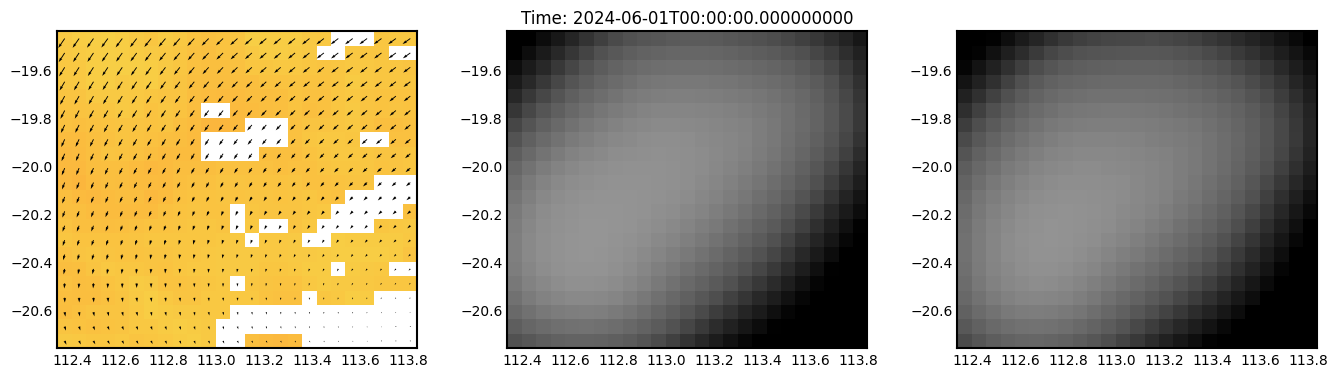

In [28]:
# from IPython.display import HTML
# %matplotlib notebook

ani = plots.plot_prediction_animation(ds_full, qv_scale=20, anim_interval=150)
ani.save(f'{crop_app}_animation_full.mp4')
# HTML(ani.to_jshtml())

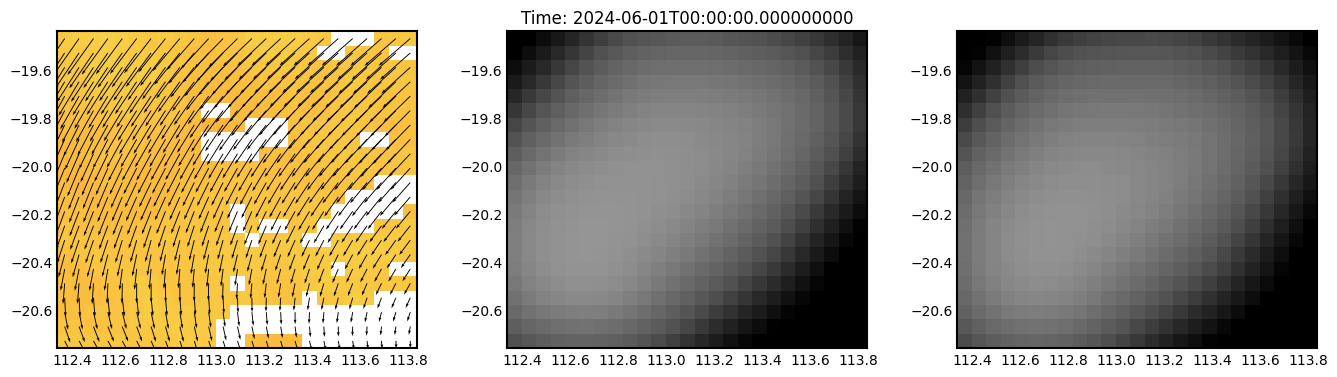

In [29]:
ani = plots.plot_prediction_animation(ds_full, qv_scale=5, u_name='mu_u_lp', v_name='mu_v_lp', anim_interval=42)
ani.save(f'{crop_app}_animation_lp60hr.mp4')